In [ ]:
# TODO
%run D:\codes\confg
%run D:\codes\arome\read_in_arome.ipynb
%run D:\codes\hatpro\read_in_hatpro.ipynb

In [1]:
""" Comparison of Temperature and Humidity of Hatpro obs. and models
- one plot at 03 UTC to add also radiosonde
- 2 hourly steps
"""
from datetime import datetime

import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from metpy.calc import specific_humidity_from_dewpoint
from metpy.units import units
from scipy.interpolate import interp1d

C:\Users\cosma\anaconda3\envs\myenv\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\cosma\anaconda3\envs\myenv\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\cosma\anaconda3\envs\myenv\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
hatpro_time = '2017-10-16T02:00:00.000000000'
model_time = '2017-10-16T03:00:00.000000000'

launch_date = pd.to_datetime('2017-10-16 02:15:05',
                             format='%Y-%m-%d %H:%M:%S')

time_for_model = pd.to_datetime('2017-10-16 03:00:00',
                                format='%Y-%m-%d %H:%M:%S')  # TODO can change here the time

In [3]:
def calc_RH(T_K, p_pa, AH_kg_m3):
    """Calculate Relative Humidity: from absolute Humidity kg/m3 to relative humidity in %"""
    rho = 1.225  # Air density (kg/m^3)

    # Calculate saturation vapor pressure (es)
    es = 611.2 * np.exp(17.67 * (T_K - 273.15) / (T_K - 29.65))

    # Calculate saturation mixing ratio (rvs)
    rvs = 0.622 * es / (p_pa - es)

    # Calculate specific humidity (qv) from AH and rho
    qv = AH_kg_m3 / rho

    # Calculate mixing ratio (rv) from specific humidity (qv)
    rv = qv / (1 - qv)

    # Calculate relative humidity (RH)
    RH = (rv / rvs) * 100.0

    return RH

In [4]:
def read_hatpro_and_calc_rh(df_arome_model):
    """Read in Hatpro (has only absolute humidity) have to calculate relativ humidity, for that I need AROME model to
    get the pressure for HATPRO """
    df = read_hatpro_extern()  # Read in the dataset
    df_hatpro_z = df.sel(height_level=slice(None, 7000))  # Select only data under 7000 m

    df_hatpro_z["height_level"] = df_hatpro_z[
                                      "height_level"] + 612  # add 612 meter where the microwave radiometer is placed

    interp_func = interp1d(df_arome_model['z'].values, df_arome_model['p'].values, kind='linear', bounds_error=False,
                           fill_value='extrapolate')

    # Interpolate pressure values onto height values of df_hatpro_z
    interpolated_p = interp_func(df_hatpro_z['height_level'])

    # Assign the interpolated pressure values to df_hatpro_z as a new DataArray
    df_hatpro_z['p_pascal'] = xr.DataArray(interpolated_p,
                                           dims='height_level')  # create a new Dataarray and assign it to the Dataset

    hpa = df_hatpro_z["p_pascal"].values
    kgm3 = df_hatpro_z["humidity"].values / 1000
    t_k = df_hatpro_z["T"].values + 273.15

    # print(df_hatpro_z)

    rh = calc_RH(T_K=t_k, p_pa=hpa, AH_kg_m3=kgm3)
    df_hatpro_z['relative_humidity'] = xr.DataArray(rh,
                                                    dims=(
                                                        'rawdate',
                                                        'height_level'))  # create a new Dataarray and assign it to the Dataset

    return df_hatpro_z

In [5]:
def read_arome(location):
    """Read in AROME Model, has specific humidity and Dewpoint"""
    # read in AROME
    my_variable_list = ["th", "p", "z", "q"]
    df_model = read_3D_variables_AROME(variables=my_variable_list, method="sel",
                                       lon=station_files_zamg[location]["lon"],
                                       lat=station_files_zamg[location][
                                           "lat"])  # if time = None it selects the whole time_range
    df_model["T_K"] = mpcalc.temperature_from_potential_temperature(pressure=df_model["p"],
                                                                    potential_temperature=df_model["th"])
    df_model["T"] = df_model["T_K"].metpy.convert_units("degC")

    df_model["Td"] = mpcalc.dewpoint_from_specific_humidity(pressure=df_model["p"],
                                                            temperature=df_model["T"],
                                                            specific_humidity=df_model["q"])

    rh = mpcalc.relative_humidity_from_dewpoint(df_model["T"], df_model["Td"])

    df_model["humidity"] = rh.metpy.convert_units("percent")  # hat 55% ganz unten
    return df_model

In [6]:
def change_height(df):
    """change the nz (from model level) to the height in meters above ground"""
    #df["nz"] = df["z"].values  # weise hier die werte zu
    df['nz'].values = df["z"].values
    df = df.rename({'nz': 'height'})
    return df

In [7]:
def model_change_height_to_agl(df):
    """change the height of the model to agl (above ground level) from the IMGI turm"""
    df["nz"] = df["z"].values
    df = df.rename({'nz': 'height'})
    ds_under_height_max = df.sel(height=df['height'].values < 4000)
    new_height_vals = ds_under_height_max["z"].values - station_files_zamg["IAO"][
        "hoehe"] - 35  # 35m is the height of the IMGI

    ds_under_height_max["z_agl"] = new_height_vals
    ds_under_height_max["z_agl"] = ds_under_height_max["z_agl"] / 1000
    return ds_under_height_max

In [8]:
def model_change_height_to_agl_ukmo(df):
    """change the height of the model to agl (above ground level) from the IMGI turm"""
    df["height"] = df["geopotential_height"].values
    ds_under_height_max = df[df['height'].values < 4000]
    new_height_vals = ds_under_height_max["height"].values - station_files_zamg["IAO"][
        "hoehe"] - 35  # 35m is the height of the IMGI

    ds_under_height_max["z_agl"] = new_height_vals
    ds_under_height_max["z_agl"] = ds_under_height_max["z_agl"] / 1000
    return ds_under_height_max

In [9]:
def convert_radiosonde_df_to_xarray():
    """read csv and convert it to xarray df"""
    df = pd.read_csv(radiosonde_csv, comment="#")

    # Drop rows with NaN values in any column
    df_cleaned = df.dropna()

    # Convert 'time' from seconds since launch to actual datetime
    df_cleaned['time'] = pd.to_timedelta(df_cleaned['time'], unit='s') + launch_date

    # convert also the units of some other variables
    df_cleaned.loc[:, 'pressure'] = df.loc[df_cleaned.index, 'pressure'] / 100
    df_cleaned.loc[:, 'dewpoint'] = df.loc[df_cleaned.index, 'dewpoint'] - 273.15
    df_cleaned.loc[:, 'temperature'] = df.loc[df_cleaned.index, 'temperature'] - 273.15

    df_unique = df_cleaned.drop_duplicates(['time', 'geopotential height'])

    # Then set the index and convert to xarray
    df_unique.set_index(['time'], inplace=True)

    u = df_unique["windspeed"].values * units.meter / units.second

    p = df_unique['pressure'].values * units.hPa
    T = df_unique['temperature'].values * units.degC
    Td = df_unique['dewpoint'].values * units.degC
    wind_speed = u.to(units.knots)
    wind_dir = df_unique['wind direction'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    z = df_unique["geopotential height"].values * units.meter

    ds = xr.Dataset()

    # Add variables to the dataset
    ds['u_wind'] = xr.DataArray(u.magnitude, dims=('time',), coords={'time': df_unique.index},
                                attrs={'units': str(u.units)})
    ds['v_wind'] = xr.DataArray(v.magnitude, dims=('time',), coords={'time': df_unique.index},
                                attrs={'units': str(v.units)})
    ds['pressure'] = xr.DataArray(p.magnitude, dims=('time',), coords={'time': df_unique.index},
                                  attrs={'units': str(p.units)})
    ds['temperature'] = xr.DataArray(T.magnitude, dims=('time',), coords={'time': df_unique.index},
                                     attrs={'units': str(T.units)})
    ds['dewpoint'] = xr.DataArray(Td.magnitude, dims=('time',), coords={'time': df_unique.index},
                                  attrs={'units': str(Td.units)})
    ds['geopotential_height'] = xr.DataArray(z.magnitude, dims=('time',), coords={'time': df_unique.index},
                                             attrs={'units': str(z.units)})

    return ds.metpy.quantify()

In [10]:
def read_radiosonde():
    """Read in the radiosonde at LOWI, has dewpoint and specific humidity"""
    # read radiosonde variablen
    ds = convert_radiosonde_df_to_xarray()

    ds = ds.isel(time=slice(4, None))  # habe unterste level weggehat

    ds["q"] = specific_humidity_from_dewpoint(ds["pressure"], ds["dewpoint"]) * units(
        "kg/kg")  # 988 * units.hPa, 15 * units.degC).to('g/kg')

    ds["T_K"] = ds["temperature"].metpy.convert_units("K")
    ds["p_pascal"] = ds['pressure'].metpy.convert_units("Pa")

    rh = mpcalc.relative_humidity_from_dewpoint(ds["temperature"], ds["dewpoint"])

    ds["relative_humidity"] = rh.metpy.convert_units("percent")  # hat 91% ganz unten

    return ds

In [11]:
def plot_comparison_T(ds_hatpro, ds_radiosonde, ds_icon_3d, ds_model_z, ds_icon, ds_wrf_helen, ds_ukmo, location):
    """Make a plot of the temperature profile each 2 hours of HATPRO vs models"""
    # Extract hobos data
    hobos_data_sorted = read_in_hobos(loc="nord", my_time=model_time)
    heights = [station_data['zsl'] for station_data in hobos_data_sorted.values()]
    temperatures = [station_data['ta'] for station_data in hobos_data_sorted.values()]

    subset = ds_hatpro.sel(rawdate=model_time)
    fig, ax = plt.subplots()

    ax.plot(temperatures, heights, label="OBS: HOBOS Nord", color=colordict["HOBOS"])
    ax.plot(subset.T, subset.height_level, label=f"OBS: HATPRO at IAO", color=colordict["HATPRO"])
    ax.plot(ds_radiosonde.temperature, ds_radiosonde.geopotential_height, label=f"OBS: Radiosonde {launch_date}",
            color=colordict["RADIOSONDE"])
    plt.plot(ds_icon_3d["temperature"].values, ds_icon_3d["z_ifc"][1:].values, label="MODEL: ICON 3D",
             color=colordict["ICON"])
    ax.plot(ds_wrf_helen["temperature"].values, ds_wrf_helen["z"].values, label="MODEL: WRF-ACINN",
            color=colordict["WRF_ACINN"])
    # ax.plot(ds_icon.temp_C, ds_icon.height, label=f"MODEL: ICON at {location}", color=colordict["ICON"]) comment out ICON Meteogram
    ax.plot(ds_model_z.T, ds_model_z.height, label=f"MODEL: AROME at {location}", color=colordict["AROME"])
    ax.plot(ds_ukmo.temperature, ds_ukmo["geopotential_height"], label=f"MODEL: UKMO at {location}",
            color=colordict["UKMO"])
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Altitude (m)')
    ax.set_title(f'Temperature Profile at {model_time}', fontsize=10)
    ax.grid(True)
    # Set x-axis and y-axis limits
    min_T_value = min([ds_hatpro.T.min().values, 0])
    max_T_value = max([ds_hatpro.T.max().values, 25])

    ax.set_xlim([min_T_value, max_T_value])
    ax.set_ylim([0, 7000])
    # Add legend
    ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.savefig(
        f"{dir_PLOTS}/hatpro/comparison_Temp_{model_time}.png",
        dpi=300,
        bbox_inches='tight')

In [12]:
def plot_comparison_rh(ds_hatpro, ds_radiosonde, ds_icon_3d, ds_model_z, ds_wrf_helen, ds_ukmo, location):
    """Plot the comparison of the RELATIVE humidity"""

    # Extract hobos data
    hobos_data_sorted = read_in_hobos(loc="nord", my_time=model_time)
    heights = [station_data['zsl'] for station_data in hobos_data_sorted.values()]
    relative_humidity = [station_data['rh'] for station_data in hobos_data_sorted.values()]

    subset = ds_hatpro.sel(rawdate=model_time)

    fig, ax = plt.subplots()

    ax.plot(relative_humidity, heights, label=f"OBS: HOBOS Nord", color=colordict["HOBOS"])
    ax.plot(subset.relative_humidity, subset.height_level, label=f"OBS: Hatpro at IAO", color=colordict["HATPRO"])

    ax.plot(ds_radiosonde.relative_humidity, ds_radiosonde.geopotential_height, label=f"OBS: Radiosonde {launch_date}",
            color=colordict["RADIOSONDE"])
    plt.plot(ds_icon_3d["relative_humidity"], ds_icon_3d["z_ifc"][1:].values, label=f"MODEL: ICON 3D at {location}",
             color=colordict["ICON"])
    ax.plot(ds_wrf_helen["relative_humidity"].values, ds_wrf_helen["z"].values, label="MODEL: WRF Helen",
            color=colordict["WRF_ACINN"])
    ax.plot(ds_model_z.humidity, ds_model_z.height, label=f"MODEL: AROME at {location}",
            color=colordict["AROME"])
    ax.plot(ds_ukmo.relative_humidity, ds_ukmo.geopotential_height, label=f"MODEL: UKMO at {location}",
            color=colordict["UKMO"])
    ax.set_xlabel('Relative Humidity (%)')
    ax.set_ylabel('Altitude (m)')
    ax.set_title(f'Relative Humidity Profile at {model_time}', fontsize=10)
    ax.grid(True)

    ax.set_ylim([0, 7000])
    # Add legend
    ax.legend()

    # Adjust layout
    plt.tight_layout()

    plt.savefig(
        f"{dir_PLOTS}/hatpro/comparison_RH_{model_time}.png",
        dpi=300,
        bbox_inches='tight')

In [13]:
def read_icon_2h_meteogram_T(my_loc, model_time):
    """read Meteogram of icon and transform height into z_agl"""
    df = read_icon_meteogram_fixed_time(my_loc, model_time)
    ds_under_height_max = df[df['height'] < 4000]
    if my_loc == "IAO":
        new_height_vals = ds_under_height_max["height"].values - station_files_zamg[f"{my_loc}"][
            "hoehe"] - 35  # 35m is the height of the IMGI
    else:
        new_height_vals = ds_under_height_max["height"].values - station_files_zamg[f"{my_loc}"][
            "hoehe"]
    ds_under_height_max["z_agl"] = new_height_vals
    ds_under_height_max["z_agl"] = ds_under_height_max["z_agl"] / 1000
    return ds_under_height_max

In [14]:
def read_icon_2h_3D_T(my_loc, day, hour):
    """read Icon 2h, convert height to z_agl (km above ground)"""

    # Extract ICON 3D at the specific point and a specified day and hour
    ds_icon_3d = read_icon_fixed_point_and_time(day=day, hour=hour,
                                                my_lon=station_files_zamg[my_loc]["lon"],
                                                my_lat=station_files_zamg[my_loc]["lat"])

    # Subtract the station height from the height variable to convert to height above ground level
    if my_loc == "IAO":
        # Adjusting height by subtracting station height and additional 35m for IMGI
        corrected_heights = ds_icon_3d["z_ifc"].values - station_files_zamg[f"{my_loc}"]["hoehe"] - 35
    else:
        # Standard adjustment by just subtracting the station height
        corrected_heights = ds_icon_3d["z_ifc"].values - station_files_zamg[f"{my_loc}"]["hoehe"]

    # Convert heights from meters to kilometers
    ds_icon_3d["z_agl"] = corrected_heights / 1000.0

    return ds_icon_3d

In [15]:
def plot_T_2hourly_steps(ds_hatpro, df_arome, my_loc):
    """Make a plot of the temperature profile each 2 hours of HATPRO vs models Some Models are read in here,
    depends on the reading routine (when they are separate files for day:hour:min then they are read in here),
    if they go continuously over the days the are given as parameters
    """
    # Create subplots
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

    index = 0
    # Iterate over subplots
    for i, ax_row in enumerate(axs):
        for j, ax in enumerate(ax_row):
            # Check if index is within bounds
            if index < len(ds_hatpro.rawdate):
                # Extract date and subset data
                total_date = pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%Y-%m-%d %H:%M%S')
                day = int(pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%d'))
                hour = int(pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%H'))

                # get AROME
                df_model_fix_time = (df_arome.sel(time=total_date))

                # get UKMO
                df_ukmo = read_ukmo_fixed_point_and_time(city_name=my_loc, time=total_date)
                df_ukmo = model_change_height_to_agl_ukmo(df_ukmo)

                # get ICON
                df_icon_2h = read_icon_2h_meteogram_T("IAO", total_date)  # meteogram

                # get WRF Helen
                df_wrf_helen = read_wrf_fixed_point_and_time(day=day, hour=hour,
                                                             latitude=station_files_zamg[my_loc]["lat"],
                                                             longitude=station_files_zamg[my_loc]["lon"], minute=0)
                df_wrf_helen_agl = model_change_height_to_agl(df_wrf_helen)

                if int(day) == 16:  # TODO wait that ICON 3D data is available also for the 15. October
                    ds_icon_3d = read_icon_2h_3D_T(my_loc, day, hour)

                ds_under_4000m = model_change_height_to_agl(df_model_fix_time)

                ax.plot(ds_under_4000m.T, ds_under_4000m.z_agl, label="MODEL: AROME", color=colordict["AROME"])
                # ax.plot(df_icon_2h.temp_C, df_icon_2h.z_agl, label="MODEL: ICON",
                #        color=colordict["ICON"])  # comment out ICON Meteogram
                ax.plot(df_wrf_helen_agl.temperature, df_wrf_helen_agl.z_agl, label="MODEL: WRF HELEN",
                        color=colordict["WRF_ACINN"])
                ax.plot(df_ukmo.temperature, df_ukmo.z_agl, label="MODEL: UKMO", color=colordict["UKMO"])
                if day == 16:
                    ax.plot(ds_icon_3d["temperature"].values, ds_icon_3d["z_agl"][1:].values,
                            label="MODEL: ICON 3D", color=colordict["ICON"])

                # HOBOS mit TOTAL_DATE
                hobos_data_sorted = read_in_hobos(loc="nord", my_time=total_date)
                heights = [station_data['zsl'] for station_data in hobos_data_sorted.values()]
                temperatures = [station_data['ta'] for station_data in hobos_data_sorted.values()]

                heights_in_agl = np.add(heights, -int(station_files_zamg["IAO"]["hoehe"]))
                heights_in_km = np.divide(heights_in_agl, 1000)

                ax.plot(temperatures, heights_in_km, label="OBS: HOBOS", color=colordict["HOBOS"])

                date = pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%H:%M')
                day = pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%Y-%m-%d')

                # HATPRO mit index
                subset = ds_hatpro.isel(rawdate=index)

                ax.plot(subset.T, subset.height_level, label="OBS: HATPRO", color=colordict["HATPRO"])
                ax.set_xlabel('Temperature (°C)')
                ax.set_ylabel('Altitude (km AGL)')
                ax.set_title(f'Temperature Profile at {day} {date}', fontsize=10)
                ax.grid(True)
                # Set x-axis and y-axis limits
                ax.set_xlim([0, 25])  # set T max and min randomly by looking
                ax.set_ylim([-0.1, 2.5])
                # Add legend
                index += 12

    ax.legend()
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"{dir_PLOTS}/hatpro/temperature_vertical_hatpro_vs_arome.png")

In [16]:
def plot_RH_2hour_steps(ds_hatpro, df_arome, my_loc):
    """Make a plot of the RELATIVE HUMIDITY profile each 2 hours of HATPRO vs models"""
    # Create subplots
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

    index = 0
    # Iterate over subplots
    for i, ax_row in enumerate(axs):
        for j, ax in enumerate(ax_row):
            # Check if index is within bounds
            if index < len(ds_hatpro.rawdate):
                # Extract date and subset data
                total_date = pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%Y-%m-%d %H:%M%S')
                day = int(pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%d'))
                hour = int(pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%H'))

                # read AROME, UKMO, WRF_HELEN
                df_model_fix_time = (df_arome.sel(time=total_date))
                ds_ukmo = model_change_height_to_agl_ukmo(
                    read_ukmo_fixed_point_and_time(city_name=my_loc, time=total_date))
                df_wrf_helen = read_wrf_fixed_point_and_time(day=day, hour=hour,
                                                             latitude=station_files_zamg[my_loc]["lat"],
                                                             longitude=station_files_zamg[my_loc]["lon"], minute=0)
                df_wrf_helen_agl = model_change_height_to_agl(df_wrf_helen)

                ds_under_4000m = model_change_height_to_agl(df_model_fix_time)
                ax.plot(ds_under_4000m.humidity, ds_under_4000m.z_agl, label="MODEL: AROME",
                        color=colordict["AROME"])
                ax.plot(ds_ukmo.relative_humidity, ds_ukmo.z_agl, label="MODEL: UKMO",
                        color=colordict["UKMO"])
                ax.plot(df_wrf_helen_agl.relative_humidity, df_wrf_helen_agl.z_agl, label="MODEL: WRF_ACINN",
                        color=colordict["WRF_ACINN"])
                if day == 16:  # TODO wait that ICON is also available for 15 OCTOBER
                    ds_icon_3d = read_icon_2h_3D_T(my_loc, day, hour)
                    ax.plot(ds_icon_3d["relative_humidity"].values, ds_icon_3d["z_agl"][1:].values,
                            label="MODEL: ICON 3D", color=colordict["ICON"])

                # HOBOS mit TOTAL_DATE
                hobos_data_sorted = read_in_hobos(loc="nord", my_time=total_date)
                heights = [station_data['zsl'] for station_data in hobos_data_sorted.values()]
                relative_humidity = [station_data['rh'] for station_data in hobos_data_sorted.values()]

                heights_in_agl = np.add(heights, -int(station_files_zamg["IAO"]["hoehe"]))
                heights_in_km = np.divide(heights_in_agl, 1000)

                ax.plot(relative_humidity, heights_in_km, label="OBS: HOBOS", color=colordict["HOBOS"])

                date = pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%H:%M')
                day = pd.to_datetime(ds_hatpro.rawdate[index].values).strftime('%Y-%m-%d')

                # HATPRO mit index
                hatpro_subset = ds_hatpro.sel(rawdate=total_date)  # hier ist problem

                ax.plot(hatpro_subset.relative_humidity, hatpro_subset.height_level, label="OBS: HATPRO",
                        color=colordict["HATPRO"])
                ax.set_xlabel('Relative Humidity (%)')
                ax.set_ylabel('Altitude (km AGL)')
                ax.set_title(f'Relative Humidity Profile at {day} {date}', fontsize=10)
                ax.grid(True)
                # Set x-axis and y-axis limits
                ax.set_xlim([0, 100])  # set T max and min randomly by looking
                ax.set_ylim([0, 2.5])
                # Add legend
                index += 12

    ax.legend()
    # Adjust layout
    plt.tight_layout()

    plt.savefig(f"{dir_PLOTS}/hatpro/relative_humidity_vertical_hatpro_vs_arome.png")

<xarray.DataArray 'humidity' (rawdate: 841, height_level: 39)> Size: 262kB
<Quantity([[7.9098 7.849  7.7635 ... 0.0601 0.0278 0.0121]
 [7.8107 7.7494 7.6638 ... 0.0595 0.0274 0.0119]
 [7.7422 7.6808 7.5952 ... 0.0591 0.0272 0.0118]
 ...
 [5.994  5.8887 5.769  ... 0.0791 0.0303 0.0114]
 [6.0192 5.9132 5.7925 ... 0.0801 0.0307 0.0115]
 [6.0549 5.9497 5.8295 ... 0.0792 0.0305 0.0115]], 'gram / meter ** 3')>
Coordinates:
  * rawdate       (rawdate) datetime64[ns] 7kB 2017-10-14 ... 2017-10-19T23:5...
  * height_level  (height_level) int32 156B 0 10 30 50 ... 7000 8000 9000 10000


Text(0.5, 1.0, 'Model time 2017-10-16 03:00, HATPRO Time: 2017-10-16 02:00')

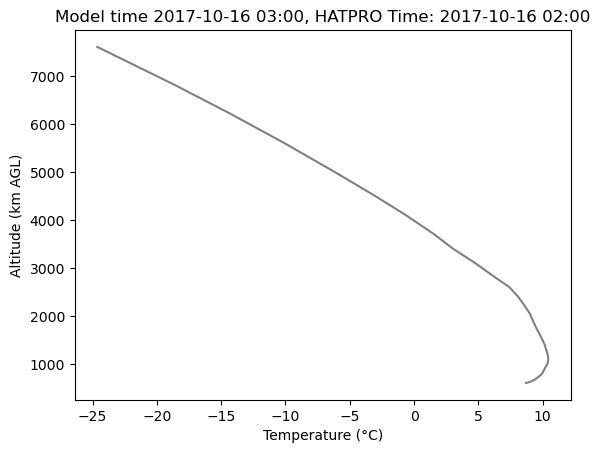

In [74]:
loc_uni = "IAO"  # UNI Innsbruck
loc_airport = "LOWI"  # FLUGHAFEN
my_loc = loc_uni  # select your location

df_arome_a = read_arome(location=my_loc)

# read in fixed time
df_arome_fixed_time = change_height(df_arome_a)
df_hatpro = read_hatpro_and_calc_rh(df_arome_fixed_time)

fig, ax = plt.subplots()

index = 0
if index < len(df_hatpro.rawdate):
    subset = df_hatpro.isel(rawdate=index)

plt.plot(subset.T, subset.height_level, label="OBS: HATPRO", color=colordict["HATPRO"])
plt.xlabel('Temperature (°C)')
plt.ylabel('Altitude (km AGL)')
plt.title(f"Model time {pd.to_datetime(model_time).strftime('%Y-%m-%d %H:%M')}, HATPRO Time: {pd.to_datetime(hatpro_time).strftime('%Y-%m-%d %H:%M')}")

#plt.savefig(f"{dir_PLOTS}/HATPRO/HATPRO.png")



